In [2]:
import gzip
import json
import re
import os
import sys
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from collections import defaultdict
import tensorflow as tf
import altair as alt
import collections

from src.utils import split_dataframe, CFModel
from src.load_data import read_tables
from src.DNN_Model import generate_dataset, build_dnn_model, make_shared_embedding_col, make_embedding_col

### load reviews and books data

In [3]:
reviews = pd.read_csv('data/cleaned_reviews_mystery_1.csv')
books = pd.read_csv('data/cleaned_books_mystery_1.csv')

In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551765 entries, 0 to 1551764
Data columns (total 9 columns):
review_id      1551765 non-null object
user_id        1551765 non-null int64
book_id        1551765 non-null int64
rating         1551765 non-null int64
timestamp      1551765 non-null object
n_votes        1551765 non-null int64
n_comments     1551765 non-null int64
old_user_id    1551765 non-null object
old_book_id    1551765 non-null int64
dtypes: int64(6), object(3)
memory usage: 106.6+ MB


In [29]:
reviews.head(2)

,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments,old_user_id,old_book_id
0,d23dc89ab32cd864e54d18369751163b,102489,37120,3,2001-01-01 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,196084
1,c7613da4cbd48baa83efec99b4dd6a41,102489,96299,3,2001-01-11 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,79030


In [5]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105365 entries, 0 to 105364
Data columns (total 12 columns):
book_id               105365 non-null int64
title                 105365 non-null object
num_pages             105365 non-null int64
is_ebook              105365 non-null int64
link                  105365 non-null object
average_rating        105365 non-null float64
ratings_count         105365 non-null int64
text_reviews_count    105365 non-null int64
author_id             105365 non-null int64
publisher             76004 non-null object
similar_books         105365 non-null object
old_book_id           105365 non-null int64
dtypes: float64(1), int64(7), object(4)
memory usage: 9.6+ MB


In [30]:
books.head(2)

,book_id,title,num_pages,is_ebook,link,average_rating,ratings_count,text_reviews_count,author_id,publisher,similar_books,old_book_id
0,75512,The House of Memory (Pluto's Snitch #2),318,1,https://www.goodreads.com/book/show/33394837-t...,4.33,269,60,242185,NaN,[],33394837
1,35550,"Dead in the Morning (Patrick Grant, #1)",0,0,https://www.goodreads.com/book/show/1902202.De...,3.3,52,8,190988,Ulverscroft,[],1902202


### generate data for dnn model

input layer: previously liked book, previously disliked book, book content features (here only include 'author_id')

In [6]:
# one-time code to generate dataset for dnn model, then save to pickle file

# dataset = generate_dataset(reviews, books, min_good_rating =4, max_num_books_per_user=20) # processed 1551000 rows
#dataset.to_pickle('data/dnn_dataset_w_books.pkl')

 processed 1551000 rows 

In [3]:
# read saved dnn-ready data

dataset = pd.read_pickle('data/dnn_dataset_w_books.pkl')

In [4]:
dataset.tail(2)

,user_id,book_id,rating,timestamp,author_id,prev_good_books,prev_bad_books
1551763,34243,78523,5,2017-11-03 21:12:55,202905,"[55927, 47953, 44562, 61742, 68857, 55357, 606...",[]
1551764,71677,82113,3,2017-11-03 22:17:08,3936,"[46538, 83396, 13821]",[22731]


### build model

In [10]:
#constraint to two previously liked and disliked books to speed up iteration

dataset['prev_good_books'] = dataset['prev_good_books'].apply(lambda x: x[:2])
dataset['prev_bad_books'] = dataset['prev_bad_books'].apply(lambda x: x[:2])

 iteration 10000: train_loss=2.825915, test_loss=6.460485
time spent for the process is 347.25079


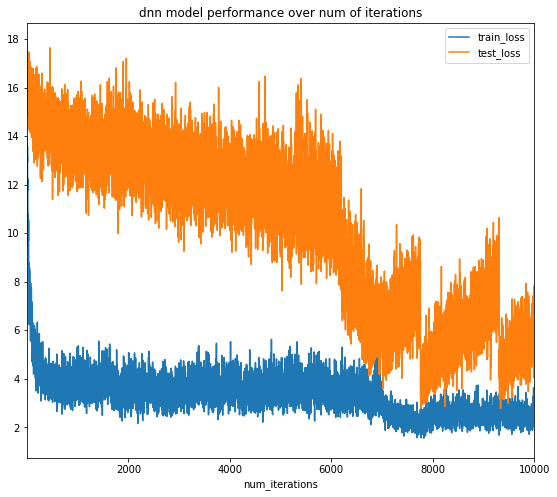

In [28]:
with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                list(dataset['book_id'].unique()), 5) + [
            make_embedding_col('author_id',list(dataset['author_id'].unique()), 5)] #input features should be string to create embedding
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model = build_dnn_model(dataset,
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1
    )
    
start_time = timeit.default_timer()
dnn_model.train( num_iterations =10000)
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

In [4]:
# constraint to 5 previously liked and disliked books

dataset['prev_good_books'] = dataset['prev_good_books'].apply(lambda x: x[:5])
dataset['prev_bad_books'] = dataset['prev_bad_books'].apply(lambda x: x[:5])

In [6]:
start_time = timeit.default_timer()
with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                list(dataset['book_id'].unique()), 5) + [
            make_embedding_col('author_id',list(dataset['author_id'].unique()), 5)] #input features should be string to create embedding
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model = build_dnn_model(dataset,
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1
    )
    
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

embedding_cols start
embedding_cols done
build_dnn_model#1 create_network
build_dnn_model#2 split train_test dataset
train_data mean rating: 3.80621
make_batch#3
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
make_batch#4
make_batch#3
make_batch#4
build_dnn_model#3


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
The old _FeatureColumn APIs are bei

 iteration 10000: train_loss=2.588658, test_loss=6.588341
time spent for the process is 573.90401 seconds


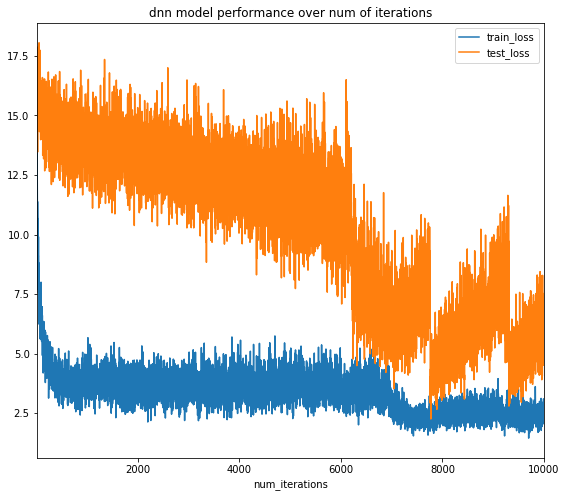

In [7]:
start_time = timeit.default_timer()
dnn_model.train( num_iterations =10000)
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

### TODO: below is testing code - to delete later

In [173]:
SAMPLE = False
if SAMPLE:
    N = 10000
    reviews = reviews[reviews['user_id']<N]
#     books = books[books['book_id'] < N]

In [174]:
def generate_dataset(reviews, books):
    MIN_GOOD_RATING = 4
    MAX_NUM_BOOKS_PER_USER = 20
    
    prev_good_books = defaultdict(set) # from user_id to a set of book_ids
    prev_bad_books = defaultdict(set)
    
    reviews_books = reviews.merge(books, how='left', on=['book_id'])
    
    reviews_books['book_id'] = reviews_books['book_id'].astype(str)
    reviews_books['user_id'] = reviews_books['user_id'].astype(str)
    reviews_books['author_id'] = reviews_books['author_id'].astype(str)
    
    
    data = []
    reviews_books = reviews_books.sort_values(by=['timestamp'])
    for i in range(reviews_books.shape[0]):
        if i % 1000 == 0:
            print("\r processed %d rows " % i, end='')
        row = reviews_books.iloc[i]
        user_id = row['user_id']
        book_id = row['book_id']
        rating = row['rating']
        
        entry = {
            'user_id': user_id,
            'book_id': book_id,
            'rating': rating,
            'timestamp': row['timestamp'],
            'author_id': row['author_id'],
            'prev_good_books':  list(prev_good_books[user_id]), # make a copy for each example
            'prev_bad_books': list(prev_bad_books[user_id])
        }
        # TODO: remove this check
        # if len(prev_good_books[user_id]) > 0 and len(prev_bad_books[user_id]) > 0:
        data.append(entry)
        
        if rating >= MIN_GOOD_RATING and len(prev_good_books[user_id])< MAX_NUM_BOOKS_PER_USER:
            prev_good_books[user_id].add(book_id)
        elif rating < MIN_GOOD_RATING and len(prev_bad_books[user_id]) < MAX_NUM_BOOKS_PER_USER:
            prev_bad_books[user_id].add(book_id)
    return pd.DataFrame(data)


In [ ]:
dataset = generate_dataset(reviews, books)

In [ ]:
# dataset = pd.read_csv('data/dnn_dataset.csv')
# import json
# def load_str(x):
#     return json.loads(x.replace("'", '"'))
# dataset['prev_good_books'] = dataset['prev_good_books'].apply(lambda x: load_str(x))
# dataset['prev_bad_books'] = dataset['prev_bad_books'].apply(lambda x: load_str(x))
# dataset['book_id'] = dataset['book_id'].astype(str)



In [177]:
book_id_vocab = books['book_id'].astype(str).unique()
books['author_id'] = books['author_id'].astype(str)
dataset[:5]

,user_id,book_id,rating,timestamp,author_id,prev_good_books,prev_bad_books
0,102489,37120,3,2001-01-01 00:00:00,114241,[],[]
1,102489,96299,3,2001-01-11 00:00:00,12608,[],[37120]
2,102489,82887,4,2001-01-25 00:00:00,21318,[],"[37120, 96299]"
3,102489,85615,2,2001-01-29 00:00:00,239471,[82887],"[37120, 96299]"
4,102489,50050,4,2001-02-02 00:00:00,1499301,[82887],"[37120, 85615, 96299]"


In [179]:
dataset['prev_good_books'] = dataset['prev_good_books'].apply(lambda x: x[:2])
dataset['prev_bad_books'] = dataset['prev_bad_books'].apply(lambda x: x[:2])

In [180]:
dataset.tail(5)

,user_id,book_id,rating,timestamp,author_id,prev_good_books,prev_bad_books
1551760,95989,59221,3,2017-11-03 14:50:16,8509533,"[46824, 62313]",[65024]
1551761,12115,80157,5,2017-11-03 17:29:55,7622802,"[11848, 88370]",[]
1551762,46579,75852,4,2017-11-03 18:42:32,14772270,"[77675, 74085]","[70445, 62583]"
1551763,34243,78523,5,2017-11-03 21:12:55,202905,"[55927, 47953]",[]
1551764,71677,82113,3,2017-11-03 22:17:08,3936,"[46538, 83396]",[22731]


In [181]:
train_dataset, test_dataset = split_dataframe(dataset)

In [182]:
print('train_data mean rating: %.5f'%train_dataset.rating.mean())

train_data mean rating: 3.80621


In [183]:
def make_batch(ratings, batch_size):
    """Creates a batch of examples.
    Args:
        ratings: A DataFrame of ratings such that examples["book_id"] is a list of
        books rated by a user.
    batch_size: The batch size.
    """
    def pad(x, fill):
        return pd.DataFrame.from_dict(x).fillna(fill).values

    features = {
      "prev_good_books": pad(ratings['prev_good_books'].values.tolist(), ""),
      "prev_bad_books": pad(ratings['prev_bad_books'].values.tolist(), ""),        
      "rating": ratings['rating'].values,
       "book_id": ratings['book_id'].values,
        "author_id": pad(ratings['author_id'].values.tolist(), "")
      }
    print('make_batch#3')    
    batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
    print('make_batch#4')    
    return batch


In [184]:
def make_shared_embedding_col(keys, shared_name, vocabulary_list, embedding_dim):
    """create shared embedding col for previously liked and disliked book_ids"""
    columns = []
    for key in keys:
        columns.append(tf.feature_column.categorical_column_with_vocabulary_list(
            key, vocabulary_list, num_oov_buckets=0))

    return tf.feature_column.shared_embedding_columns(
        columns, shared_embedding_collection_name=shared_name, dimension=embedding_dim)

def make_embedding_col(key, embedding_dim):
    """create embedding col for book content features"""
    categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=key, vocabulary_list=list(set(books[key].values)), num_oov_buckets=0)
    return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      # default initializer: trancated normal with stddev=1/sqrt(dimension)
      combiner='mean')
    
def mean_square_error_loss(batch_user_embeddings, book_embeddings, batch_book_ids, labels):
    user_emb_dim = batch_user_embeddings.shape[1].value
    book_emb_dim = book_embeddings.shape[1].value
    if user_emb_dim != book_emb_dim:
        raise ValueError('The user embedding dimension %d should match the book embedding dimension %d' %(
                user_emb_dim, book_emb_dim))
        
    batch_book_embeddings = tf.gather(book_embeddings, tf.strings.to_number(batch_book_ids, out_type=tf.dtypes.int32))
    
    batch_predictions = tf.reduce_sum(
        batch_user_embeddings * batch_book_embeddings, axis=1)
    
    loss = tf.compat.v1.losses.mean_squared_error(labels, batch_predictions)
    return loss

def build_dnn_model(train_dataset, test_dataset, embedding_cols, hidden_dims, learning_rate =1,):
    print('build_dnn_model#1')
    def create_network(features):
        #create a bog-of-words embedding for each sparse feature
        inputs = tf.feature_column.input_layer(features, embedding_cols)
        #hidden layer
        input_dim = inputs.shape[1].value
        for i, output_dim in enumerate(hidden_dims):
            w = tf.get_variable(
                'hidden%d_w_'% i, shape=[input_dim, output_dim],
                initializer=tf.truncated_normal_initializer(
                stddev=1./np.sqrt(output_dim)))/10
            outputs = tf.matmul(inputs, w)
            input_dim = output_dim
            inputs = outputs
        return outputs
    
    print('build_dnn_model#2')    
    train_batch = make_batch(train_dataset, 200)
    test_batch = make_batch(test_dataset, 100)
    print('build_dnn_model#3')    
    with tf.variable_scope('model', reuse=False):
        #train
        train_user_embeddings =create_network(train_batch)
        train_labels = train_batch['rating']
        train_book_ids = train_batch['book_id']
        
    with tf.variable_scope('model', reuse=True):
        #test
        test_user_embeddings = create_network(test_batch)
        test_labels = test_batch['rating']
        test_book_ids = test_batch['book_id']
        
        book_embeddings = tf.get_variable("input_layer/book_id_embedding/embedding_weights")
        
    print('build_dnn_model#4')        
    train_loss = mean_square_error_loss(train_user_embeddings, book_embeddings, train_book_ids, train_labels)
    test_loss = mean_square_error_loss(test_user_embeddings, book_embeddings, test_book_ids, test_labels)
    
#     _, test_prediction_at_10 = tf.metrics.precision_at_k(
#         labels=test_labels, predictions=tf.matmul(test_user_embeddings, book_embeddings, transpose_b=True),
#         k=10)
    
    metrics=(
        {'train_loss': train_loss, 'test_loss': test_loss},
        # {'test_precision_at_10': test_prediction_at_10}
    )
    embeddings = {'book_id': book_embeddings}
    return CFModel(embeddings, train_loss, metrics, learning_rate=learning_rate)


with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                book_id_vocab, 5) + [make_embedding_col('author_id',5)]
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model = build_dnn_model(
        train_dataset, test_dataset, 
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1
    )
    


embedding_cols start
embedding_cols done
build_dnn_model#1
build_dnn_model#2
make_batch#3
make_batch#4
make_batch#3
make_batch#4
build_dnn_model#3
build_dnn_model#4
_train_init
_train_init done


 iteration 10000: train_loss=3.033715, test_loss=4.769547

No handles with labels found to put in legend.


({'train_loss': 3.0337145, 'test_loss': 4.769547}, {})

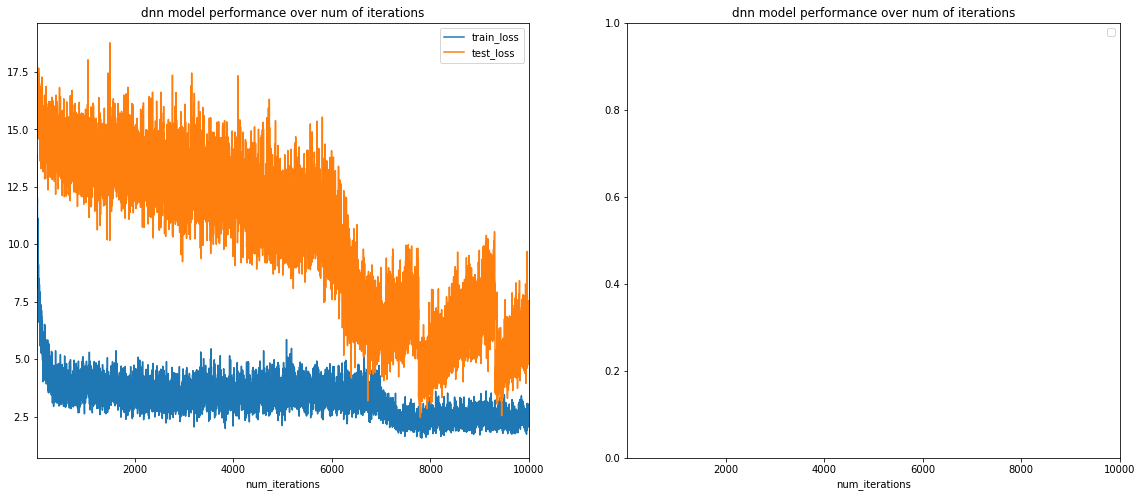

In [185]:
dnn_model.train( num_iterations =10000)